### Welcome

This notebook is used for the accuracy assessment of modal filters. It uses data for Newcastle Upon Tyne. If you create your own manual classification of modal filters, you should be able to use this same code with minor adjustments!

In [1]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
from shapely import Polygon
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from itertools import product
from shapely.geometry import MultiPolygon

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] + ['waterway']
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )

C:\Users\b8008458\AppData\Local\Temp\ipykernel_23292\305956182.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True,


In [3]:
# set place
place = "Newcastle Upon Tyne, United Kingdom"

In [4]:
#  boundary

boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)


# plot boundary (always best to double check!)
boundary.explore()

In [20]:
## get street network for the study area

# get the boundary in the correct CRS for OSMnx
boundary_4326 = boundary.to_crs('EPSG:4326')

# OSM is used over OS datasets as OSM is better for non-driving streets
streets = ox.graph_from_polygon(boundary_4326.geometry.iloc[0], network_type='all')

# Convert the OSMnx graph to a GeoDataFrame of streets
streets_gdf = ox.graph_to_gdfs(streets, nodes=False, edges=True)

In [21]:
## get filters

tags = {"barrier": ["bollard", "bus_trap", "entrance", "planter", "sump_buster", "wedge"]}

## get barrier filters
# get the boundary in the correct CRS for OSMnx
boundary_4326 = boundary.to_crs('EPSG:4326')

# Use ox.features_from_polygon to find features matching the specified tags
barriers = ox.features_from_polygon(polygon = boundary_4326.geometry.iloc[0], tags = tags)




## process any linestrings into point geometries

# Filter the GeoDataFrame to select only rows with "linestring" geometry
barriers_linestrings = barriers[barriers['geometry'].geom_type == 'LineString']

# Create an empty GeoDataFrame to store the individual points
points_gdf = gpd.GeoDataFrame(columns=list(barriers_linestrings.columns), crs=barriers_linestrings.crs)

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Create a GeoDataFrame from the individual points and copy the attributes
        points_df = gpd.GeoDataFrame(geometry=points, crs=barriers_linestrings.crs)
        for col in barriers_linestrings.columns:
            if col != 'geometry':
                points_df[col] = row[col]
        
        # Rename the "geometry" column to "merged_geometry"
        points_df = points_df.rename(columns={'geometry': 'merged_geometry'})
        
        # Append the points to the points_gdf
        points_gdf = pd.concat([points_gdf, points_df], ignore_index=True)

# Now, points_gdf contains all the individual points from the linestrings with inherited attributes

# Remove the "geometry" column from the points GeoDataFrame
points_gdf = points_gdf.drop(columns=['geometry'])

# Remove the linestring rows from the original GeoDataFrame
barriers = barriers[barriers['geometry'].geom_type != 'LineString']

# Rename the "merged_geometry" column to "geometry" in the points GeoDataFrame
points_gdf = points_gdf.rename(columns={'merged_geometry': 'geometry'})

# Concatenate the individual points GeoDataFrame to the original GeoDataFrame
barriers = pd.concat([barriers, points_gdf], ignore_index=True)

# Reset the index to ensure it is continuous
barriers.reset_index(drop=True, inplace=True)

# Create a new column "previously_linestring" and set it to False initially
barriers['previously_linestring'] = False

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Iterate through the points in the linestring
        for point in points:
            # Check if the point's geometry intersects with any of the original linestrings
            mask = barriers['geometry'].intersects(point)
            if mask.any():
                # If the point intersects with any linestring, set "previously_linestring" to True
                barriers.loc[mask, 'previously_linestring'] = True

# add a unique ID
barriers['barrier_id'] = range(1, len(barriers) + 1)


# join the barriers to the streets 
streets_gdf = gpd.sjoin(streets_gdf, barriers, how = "left", op="intersects")

# clean geodataframe and drop streets without a barrier
streets_gdf.columns = streets_gdf.columns.str.replace("_right", "_barrier").str.replace("_left","_street")
# we need to double check the name of "barrier"
streets_gdf['barrier_barrier'] = streets_gdf['barrier'] if 'barrier' in streets_gdf.columns else streets_gdf['barrier_barrier']

if 'name_street' in streets_gdf.columns:
    streets_gdf = streets_gdf.rename(columns={'name_street': 'name'})
barrier_streets = streets_gdf.dropna(subset=['barrier_barrier'])

# add barrier tag
barrier_streets['filter_type'] = 'barrier or bollard'


## extract points which are on/within 1m of streets only
streets_gdf['has_barrier'] = 'yes'

# reset crs before spatail join
barriers, streets_gdf = barriers.to_crs(3857), streets_gdf.to_crs(3857)

barriers = gpd.sjoin_nearest(barriers, streets_gdf, how = "left", max_distance = 1)
barriers = barriers.dropna(subset=['has_barrier'])
barriers = barriers.reset_index(drop=True)  # Reset the index
# Dissolve based on the 'geometry' column

# re-reset crs 
barriers, streets_gdf = barriers.to_crs(4326), streets_gdf.to_crs(4326)

# we need to double check the name of "barrier_id"
import numpy as np
streets_gdf['barrier_id_right'] = streets_gdf['barrier_id'] if 'barrier_id' in streets_gdf.columns else streets_gdf['barrier_id_right']
# dissolve
barriers = barriers.dissolve(by='barrier_id_right')
# add barrier tag
barriers['filter_type'] = 'barrier or bollard'
# Reset the index to remove multi-index
barriers.reset_index(drop=True, inplace=True)

## get bus gates

# we need to double check the name of "access"
streets_gdf['access_street'] = streets_gdf['access'] if 'access' in streets_gdf.columns else streets_gdf['access_street']
streets_gdf['bicycle_street'] = streets_gdf['bicycle'] if 'bicycle' in streets_gdf.columns else streets_gdf['bicycle_street']
streets_gdf['bus'] = streets_gdf['bus_street'] if 'bus_street' in streets_gdf.columns else streets_gdf['bus']


busgates = streets_gdf[((streets_gdf["bus"] == "yes") & (streets_gdf["access_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")) |
                    (streets_gdf["bus"] == "yes") & (streets_gdf["motor_vehicle_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")
                    ]

# add bus gate tag
busgates['filter_type'] = 'bus gate'


## cycle contra-flows
oneways = streets_gdf[(streets_gdf["oneway"] == True) & (streets_gdf["oneway:bicycle"] == "no")]

# we dissolve the roads with the same name as to not miscount the total number of oneways
# Convert values in the "name" column to strings if they are not already
oneways['name'] = oneways['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# Perform dissolve 
oneways = oneways.dissolve(by='name')

# Reset the index 
oneways = oneways.reset_index()



# add one way tag
oneways['filter_type'] = 'one-way bike'


## street continunations

def filter_streets_continuations(input_gdf):
    ## clean dataframe
    # Check if 'highway_street' column exists and rename it to 'highway'
    if 'highway_street' in input_gdf.columns:
        input_gdf.rename(columns={'highway_street': 'highway'}, inplace=True)




    # filter dataframe 
    ## remove indoor roads, these are likey pedestrian only however often don't have any "cycling" related tag
    if 'covered' in input_gdf.columns:
        input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'covered' in str(x))]
        input_gdf = input_gdf[input_gdf['covered'] != 'yes']
    ## also remove footways and steps, as these are almost pedestrain only, never cyclable
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'footway' in str(x))]
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'steps' in str(x))]



    ## clean dataframe
    input_gdf['name'] = input_gdf['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
    input_gdf['highway'] = input_gdf['highway'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))




    ## perform street continunation filtering
    # Grouping by 'name' and checking for groups with 'pedestrian' and another highway type
    grouped = input_gdf.groupby('name').filter(lambda x: any('pedestrian' in val for val in x['highway']) and len(x['highway'].unique()) > 1)
    street_continuations_gdf = grouped[grouped['highway'].str.contains('pedestrian', case=False, na=False)] # Extracting the rows containing 'pedestrian' in the highway column

    ## deal with nan names


    ## dissolve lines that are very very close to each other
    if not street_continuations_gdf.empty:
        street_continuations_gdf = street_continuations_gdf.to_crs('27700')
        street_continuations_gdf['buffer'] = street_continuations_gdf.geometry.buffer(1)
        dissolved = street_continuations_gdf.dissolve(by='name')
        
        # If a MultiPolygon is formed, convert it to individual polygons
        if isinstance(dissolved.geometry.iloc[0], MultiPolygon):
            dissolved = dissolved.explode()
        
        # Remove the buffer column
        dissolved = dissolved.drop(columns='buffer')
        street_continuations_gdf = dissolved.to_crs('4326')

    return street_continuations_gdf



# get street continunations
streets_continuations_gdf = filter_streets_continuations(streets_gdf)

# add street conitinuation tag
streets_continuations_gdf['filter_type'] = 'street continuation'


# join filters
filters = gpd.GeoDataFrame(pd.concat([barriers, busgates, oneways, streets_continuations_gdf], ignore_index=True))

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [22]:
## read in manually classified points and lines


# Load manually classified lines and points
manual_lines = gpd.read_file(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\manual_classification_modal_filter_lines.gpkg')
manual_points = gpd.read_file(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\manual_classification_modal_filter_points.gpkg')

## change crs to BNG

manual_lines = manual_lines.to_crs(27700)
manual_points = manual_points.to_crs(27700)
auto_filters = filters.to_crs(27700)

#manual_filters = gpd.GeoDataFrame(pd.concat([manual_lines, manual_points], ignore_index=True))

## clean gdfs
# Remove all columns except 'geometry' and 'filter_type' from auto_lines
auto_filters = auto_filters[['geometry', 'filter_type']]




## preprocessing of manual points
manual_points['Barrier'] = True

manual_filters = gpd.GeoDataFrame(pd.concat([manual_lines, manual_points], ignore_index=True))

# Rename the column headers
manual_filters.rename(columns={
    'bus_gate': 'bus gate',
    'street_continuation': 'street continuation',
    'contra_flow': 'one-way bike',
    'Barrier': 'barrier or bollard'
}, inplace=True)

columns_to_combine = ["bus gate", "one-way bike", "street continuation", "barrier or bollard"]

# Melt the specified columns into a new DataFrame
melted_manual_filters = pd.melt(manual_filters, id_vars=['geometry'], value_vars=columns_to_combine, var_name='filter_type', value_name='filter_value')

# Drop rows where filter_value is False or NaN
melted_manual_filters = melted_manual_filters[melted_manual_filters['filter_value'].notna() & melted_manual_filters['filter_value']]

# Group by geometry and concatenate filter types
combined_filter_types = melted_manual_filters.groupby('geometry')['filter_type'].apply(list).reset_index()

# Merge combined_filter_types back to manual_filters based on geometry
manual_filters = manual_filters.merge(combined_filter_types, on='geometry', how='left')


manual_filters['filter_type'] = manual_filters['filter_type'].apply(lambda x: ', '.join(x))

# clean gdf
manual_filters.drop(columns=['bus gate', 'one-way bike', 'street continuation', 'barrier or bollard'], inplace=True)




In [23]:
manual_filters

,geometry,filter_type
0,"LINESTRING (419886.816 564292.328, 419895.123 ...",street continuation
1,"LINESTRING (422968.752 564950.742, 422964.094 ...",street continuation
2,"LINESTRING (423085.242 564842.055, 423109.409 ...",street continuation
3,"LINESTRING (423078.823 564842.936, 423050.393 ...",street continuation
4,"LINESTRING (423156.877 565007.147, 423160.401 ...",street continuation
...,...,...
397,POINT (426846.203 564990.091),barrier or bollard
398,POINT (426571.056 565105.135),barrier or bollard
399,POINT (426497.486 565587.208),barrier or bollard
400,POINT (429228.629 564443.322),barrier or bollard


In [24]:
auto_filters

,geometry,filter_type
0,POINT (425607.401 567168.968),barrier or bollard
1,POINT (424660.040 564684.505),barrier or bollard
2,POINT (425995.872 565843.033),barrier or bollard
3,POINT (424992.099 567010.765),barrier or bollard
4,POINT (424996.735 567120.884),barrier or bollard
...,...,...
321,"LINESTRING (427573.308 563512.160, 427574.657 ...",street continuation
322,"MULTILINESTRING ((425501.309 568472.432, 42549...",street continuation
323,"MULTILINESTRING ((424959.919 564840.609, 42495...",street continuation
324,"LINESTRING (429765.530 565439.208, 429735.889 ...",street continuation


In [25]:
## Buffer manual lines by 10 meters and preserve the filter type
buffered_manual_geometries = [geom.buffer(10) for geom in manual_filters['geometry']]
buffered_manual_filters = gpd.GeoDataFrame(geometry=buffered_manual_geometries, crs=manual_filters.crs)
buffered_manual_filters['filter_type'] = manual_filters['filter_type']

In [28]:
# Split auto_filters into separate DataFrames based on filter_type
auto_filters_split = {}
for filter_type, group in auto_filters.groupby('filter_type'):
    auto_filters_split[f"{filter_type}_auto_filters"] = group

# Split buffered_manual_filters into separate DataFrames based on filter_type
buffered_manual_filters_split = {}
for filter_type, group in buffered_manual_filters.groupby('filter_type'):
    buffered_manual_filters_split[f"{filter_type}_manual_filters"] = group

barrier_or_bollard_auto_filters = auto_filters_split['barrier or bollard_auto_filters']
bus_gate_auto_filters = auto_filters_split['bus gate_auto_filters']
one_way_bike_auto_filters = auto_filters_split['one-way bike_auto_filters']
street_continuation_auto_filters = auto_filters_split['street continuation_auto_filters']

# Accessing individual GeoDataFrames from buffered_manual_filters_split dictionary
barrier_or_bollard_manual_filters = buffered_manual_filters_split['barrier or bollard_manual_filters']
bus_gate_manual_filters = buffered_manual_filters_split['bus gate_manual_filters']
one_way_bike_manual_filters = buffered_manual_filters_split['one-way bike_manual_filters']
street_continuation_manual_filters = buffered_manual_filters_split['street continuation_manual_filters']


In [30]:

# Initialize a dictionary to store spatial join results
spatial_join_results = {}

# Define a list of filter types from manual and auto
manual_filter_types = ['barrier or bollard', 'bus gate', 'one-way bike', 'street continuation']
auto_filter_types = ['barrier or bollard', 'bus gate', 'one-way bike', 'street continuation']

# Iterate through each combination of filter types
for manual_type, auto_type in product(manual_filter_types, auto_filter_types):
    # Perform spatial join between manual and auto filters for the current pair of filter types
    current_spatial_join = gpd.sjoin(auto_filters, 
                                      manual_filters[manual_filters['filter_type'] == manual_type], 
                                      how='inner', op='intersects')
    
    # Store the spatial join result in the dictionary
    spatial_join_results[f"{manual_type}_to_{auto_type}"] = current_spatial_join

# Accessing individual GeoDataFrames from spatial_join_results dictionary
barrier_or_bollard_to_bus_gate = spatial_join_results['barrier or bollard_to_bus gate']
barrier_or_bollard_to_one_way_bike = spatial_join_results['barrier or bollard_to_one-way bike']
barrier_or_bollard_to_street_continuation = spatial_join_results['barrier or bollard_to_street continuation']

bus_gate_to_barrier_or_bollard = spatial_join_results['bus gate_to_barrier or bollard']
bus_gate_to_one_way_bike = spatial_join_results['bus gate_to_one-way bike']
bus_gate_to_street_continuation = spatial_join_results['bus gate_to_street continuation']

one_way_bike_to_barrier_or_bollard = spatial_join_results['one-way bike_to_barrier or bollard']
one_way_bike_to_bus_gate = spatial_join_results['one-way bike_to_bus gate']
one_way_bike_to_street_continuation = spatial_join_results['one-way bike_to_street continuation']

street_continuation_to_barrier_or_bollard = spatial_join_results['street continuation_to_barrier or bollard']
street_continuation_to_bus_gate = spatial_join_results['street continuation_to_bus gate']
street_continuation_to_one_way_bike = spatial_join_results['street continuation_to_one-way bike']


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and

In [34]:
# Filter auto_filters for 'one_way_bike' filter_type
one_way_bike_auto_filters = auto_filters[auto_filters['filter_type'] == 'one-way bike']

# Explore the subset GeoDataFrame
one_way_bike_auto_filters.explore()

In [32]:
one_way_bike_to_street_continuation.explore()

In [44]:
from itertools import product

# Define a list of filter types from manual and auto
manual_filter_types = ['barrier or bollard', 'bus gate', 'one-way bike', 'street continuation']
auto_filter_types = ['barrier or bollard', 'bus gate', 'one-way bike', 'street continuation']

# Initialize a dictionary to store accuracy results for each pair of filter types
accuracy_results = {}

# Iterate through each combination of filter types
for manual_type, auto_type in product(manual_filter_types, auto_filter_types):
    # Perform spatial join between manual and auto filters for the current pair of filter types
    current_spatial_join = gpd.sjoin(auto_filters_split[f"{auto_type}_auto_filters"], 
                                      buffered_manual_filters_split[f"{manual_type}_manual_filters"], 
                                      how='inner', op='intersects')
    
    # Count unique geometries
    num_intersections = current_spatial_join['geometry'].nunique()
    
    # Calculate total number of geometries in auto_filters for the current filter type
    total_geometries_auto_filters = len(auto_filters_split[f"{auto_type}_auto_filters"])
    
    # Calculate percentage accuracy for the current pair of filter types
    percentage_accuracy = (num_intersections / total_geometries_auto_filters) * 100
    
    # Store the accuracy result in the dictionary
    accuracy_results[f"{manual_type}_to_{auto_type}"] = percentage_accuracy

# Print the accuracy results
for key, value in accuracy_results.items():
    print(f"Accuracy for {key}: {value}%")

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and

Accuracy for barrier or bollard_to_barrier or bollard: 80.76923076923077%
Accuracy for barrier or bollard_to_bus gate: 0.0%
Accuracy for barrier or bollard_to_one-way bike: 0.0%
Accuracy for barrier or bollard_to_street continuation: 47.5609756097561%
Accuracy for bus gate_to_barrier or bollard: 0.0%
Accuracy for bus gate_to_bus gate: 90.9090909090909%
Accuracy for bus gate_to_one-way bike: 14.285714285714285%
Accuracy for bus gate_to_street continuation: 8.536585365853659%
Accuracy for one-way bike_to_barrier or bollard: 0.4807692307692308%
Accuracy for one-way bike_to_bus gate: 0.0%
Accuracy for one-way bike_to_one-way bike: 85.71428571428571%
Accuracy for one-way bike_to_street continuation: 6.097560975609756%
Accuracy for street continuation_to_barrier or bollard: 23.076923076923077%
Accuracy for street continuation_to_bus gate: 36.36363636363637%
Accuracy for street continuation_to_one-way bike: 7.142857142857142%
Accuracy for street continuation_to_street continuation: 78.0487804

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


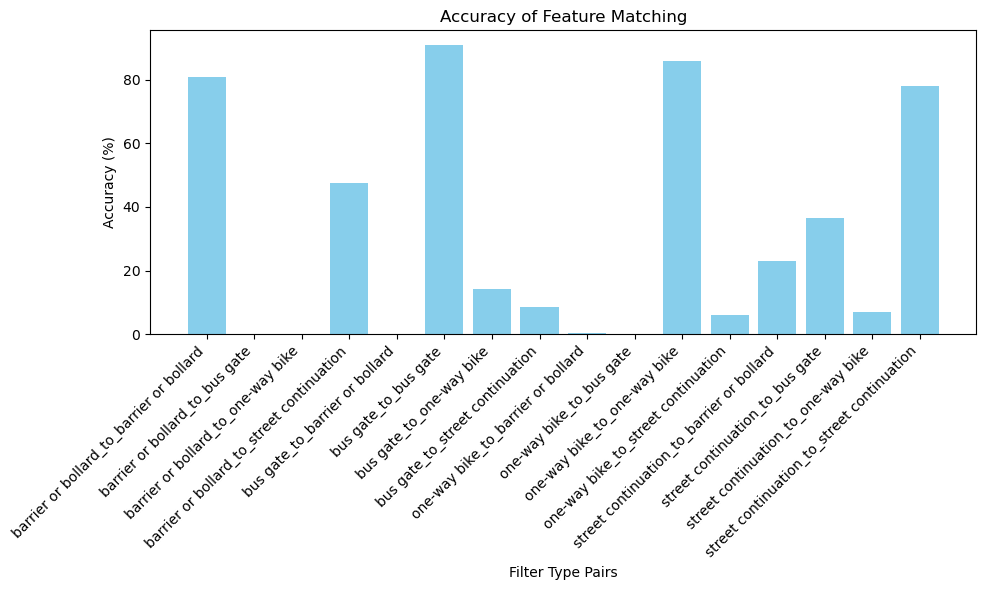

In [51]:
labels = list(accuracy_results.keys())
accuracy_values = list(accuracy_results.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracy_values, color='skyblue')
plt.xlabel('Filter Type Pairs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Feature Matching')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

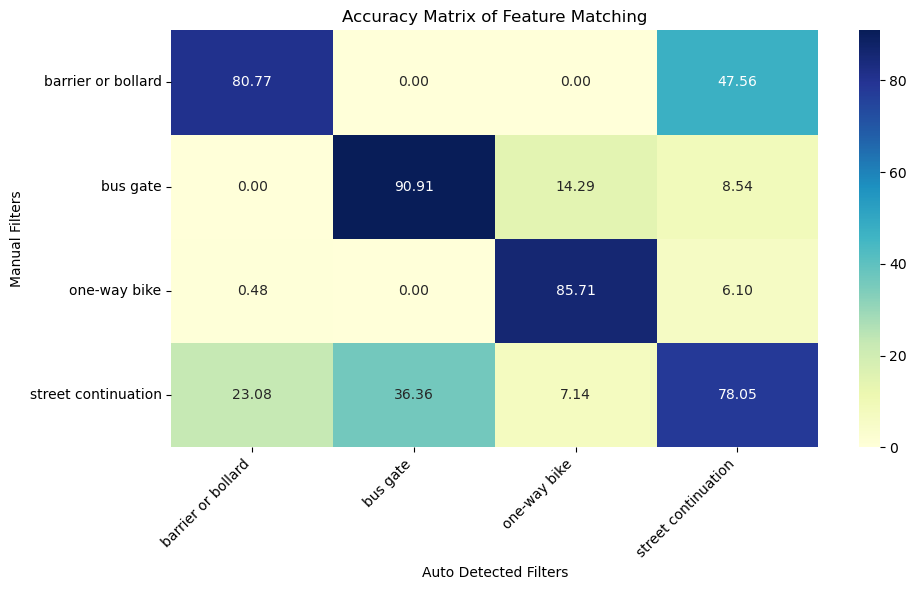

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt



# Creating a matrix plot
accuracy_matrix = []
for manual_type in manual_filter_types:
    row = []
    for auto_type in auto_filter_types:
        row.append(accuracy_results[f"{manual_type}_to_{auto_type}"])
    accuracy_matrix.append(row)

plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=auto_filter_types, yticklabels=manual_filter_types)
plt.xlabel('Auto Detected Filters')
plt.ylabel('Manual Filters')
plt.title('Accuracy Matrix of Feature Matching')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
## Overall filter detection accuracy
spatial_join = gpd.sjoin(auto_filters, buffered_manual_filters, how='inner', op='intersects')


# Count unique geometries
num_intersections = spatial_join['geometry'].nunique()

print("Number of unique intersecting geometries:", num_intersections)

# Calculate total number of geometries in auto_filters
total_geometries_auto_filters = len(auto_filters)

# Calculate percentage accuracy
percentage_accuracy = (num_intersections / total_geometries_auto_filters) * 100

print("Percentage accuracy:", percentage_accuracy, "%")

In [ ]:
# Filter correctly matched intersections
correctly_matched = spatial_join[spatial_join['filter_type'] == spatial_join['filter_types']]

# Filter missed intersections
missed_intersections = spatial_join[spatial_join['filter_type'] != spatial_join['filter_types']]

# Display the correctly matched intersections
print("Correctly Matched Intersections:")
print(correctly_matched)

# Display the missed intersections
print("\nMissed Intersections:")
print(missed_intersections)


In [ ]:
# Count total number of intersections
total_intersections = len(spatial_join)

print("Total number of intersections:", total_intersections)

# Calculate total number of geometries in auto_filters
total_geometries_auto_filters = len(auto_filters)

# Calculate percentage accuracy
percentage_accuracy = (total_intersections / total_geometries_auto_filters) * 100

print("Percentage accuracy:", percentage_accuracy, "%")


In [ ]:
# Find all unique values within the 'filter_type' column in auto_lines
unique_filter_types = auto_filters['filter_type'].unique()

# Print the unique values
print(unique_filter_types)


In [ ]:
spatial_join

In [ ]:
spatial_join.explore()

In [ ]:
# Buffer manual lines by 10 meters
buffered_manual_lines = manual_lines.geometry.buffer(10)

# Create a new GeoDataFrame to store the buffered geometries
buffered_manual_gdf = gpd.GeoDataFrame(geometry=buffered_manual_lines)

# Perform spatial join using intersect
spatial_join = gpd.sjoin(auto_lines, buffered_manual_gdf, how='inner', op='intersects')

# Filter out 'barrier or bollard' from both GeoDataFrames
auto_lines_filtered = auto_lines[auto_lines['filter_type'] != 'barrier or bollard']
manual_lines_filtered = manual_lines.dropna(subset=['bus_gate', 'street_continuation', 'contra_flow'])

# Create a list to store matched lines
matched_lines_data = []

# Iterate through the spatial join result
for idx, row in spatial_join.iterrows():
    auto_filter_type = row['filter_type']
    manual_filter_type = ''
    # Determine manual filter type based on available columns
    if 'bus_gate' in row.index and row['bus_gate']:
        manual_filter_type = 'bus gate'
    elif 'street_continuation' in row.index and row['street_continuation']:
        manual_filter_type = 'street continuation'
    elif 'contra_flow' in row.index and row['contra_flow']:
        manual_filter_type = 'one-way bike'
    
    # Append row as dictionary to the list
    matched_lines_data.append({'geometry': row['geometry'], 
                               'auto_filter_type': auto_filter_type,
                               'manual_filter_type': manual_filter_type})

# Create GeoDataFrame from the list
matched_lines = gpd.GeoDataFrame(matched_lines_data, columns=['geometry', 'auto_filter_type', 'manual_filter_type'])

# Calculate accuracy of filter type classification
total_matched = len(matched_lines[matched_lines['auto_filter_type'] == matched_lines['manual_filter_type']])
total_auto = len(matched_lines)

# Check if total_auto is zero to avoid ZeroDivisionError
if total_auto == 0:
    print("No spatially matched lines found.")
else:
    accuracy = total_matched / total_auto
    # Print accuracy
    print("Total matched lines:", total_matched)
    print("Total auto lines:", total_auto)
    print("Accuracy:", accuracy)

In [ ]:
manual_lines

In [ ]:
auto_lines['filter_type']

In [ ]:
# Find all unique values within the 'filter_type' column in auto_lines
unique_filter_types = auto_lines['filter_type'].unique()

# Print the unique values
print(unique_filter_types)


In [ ]:
manual_lines

In [ ]:
filters

In [ ]:
# Tolerance distance for spatial comparison
tolerance = 10  

# Function to check if two geometries are within tolerance distance
def within_tolerance(geom1, geom2, tolerance):
    return geom1.distance(geom2) <= tolerance

# Initialize counters
total_matched = 0
total_auto_lines = len(filters[filters.geometry.type == 'LineString'])
total_auto_points = len(filters[filters.geometry.type == 'Point'])
total_manual_lines = len(manual_lines)
total_manual_points = len(manual_points)

# Spatial join of manual points to manual lines
joined_points_lines = gpd.sjoin(manual_points, manual_lines, how='inner', op='intersects')

# Spatial join of automatic points to manual points
joined_auto_manual_points = gpd.sjoin(filters[filters.geometry.type == 'Point'], manual_points, how='inner', op='intersects')

# Spatial join of automatic lines to manual lines
joined_auto_manual_lines = gpd.sjoin(filters[filters.geometry.type == 'LineString'], manual_lines, how='inner', op='intersects')

# Loop through each automatic point
for idx, auto_row in joined_auto_manual_points.iterrows():
    auto_geom = auto_row.geometry
    manual_geom = manual_points.loc[auto_row['index_right']].geometry
    if within_tolerance(auto_geom, manual_geom, tolerance):
        total_matched += 1

# Loop through each automatic line
for idx, auto_row in joined_auto_manual_lines.iterrows():
    auto_geom = auto_row.geometry
    manual_geom = manual_lines.loc[auto_row['index_right']].geometry
    if within_tolerance(auto_geom, manual_geom, tolerance):
        total_matched += 1

# Calculate accuracy
accuracy = total_matched / (total_auto_lines + total_auto_points)

# Print results
print("Total automatic lines:", total_auto_lines)
print("Total automatic points:", total_auto_points)
print("Total manual lines:", total_manual_lines)
print("Total manual points:", total_manual_points)
print("Total matched features:", total_matched)
print("Accuracy:", accuracy)